In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
import seaborn as sns

In [3]:
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig

In [4]:
# for handling emojis
import demoji

In [5]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Part 3: Transfer Learning Using Pre-trained BERT Models

In [6]:
datapath = '../data/interim/'

In [7]:
train_df = pd.read_csv(datapath + 'interim_train_df.csv')

In [8]:
train_df.head()

,text,Disaster
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
print(train_df.shape)

(7613, 2)


In [10]:
test_df = pd.read_csv(datapath + 'interim_test_df.csv')
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


## Basic Text Preprocessing

Source: https://swatimeena989.medium.com/distilbert-text-classification-using-keras-c1201d3a3d9d

In [11]:
def unicode_to_ascii(text):
    return ''.join(word for word in unicodedata.normalize('NFD', text) if unicodedata.category(word) != 'Mn')

def clean_stopwords_shortwords(text):
    stopwords_list=stopwords.words('english')
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = re.sub(r"http\S+", "", w) # removing url is added after training the BertDistill model
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = clean_stopwords_shortwords(w)
    w = demoji.replace(w, '') #remove emoijis
    w = re.sub(r'@\w+', '',w)
    return w

In [12]:
train_df['text']=train_df['text'].map(preprocess_sentence)
test_df['text']=test_df['text'].map(preprocess_sentence)

# Tweets Classification using DistilBERT with Keras

- For the sake of reducing the cost of computations to train the model, DistilBERT is used. According to the [HuggingFace](https://huggingface.co/transformers/model_doc/distilbert.html), DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.



## Loading DistilBERT Tokenizer and model

In [13]:
# loading DistilBert Tokenizer
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [14]:
# loading DistilBert Tokenizer
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Feature Engineering: Transforming input data for DistilBERT model

In [15]:
max_len = 32 # the maximum lenght of tokanized tweet (sequence)
sentences=train_df['text'].values
labels=train_df['Disaster'].values
len(sentences), len(labels)

(7613, 7613)

- Example of the tokanizer outpot

In [16]:
dbert_tokenizer.tokenize(sentences[4])


['got',
 'sent',
 'photo',
 'ruby',
 'alaska',
 'smoke',
 'wild',
 '##fires',
 'pour',
 '##s',
 'school']

In [17]:
dbert_inp = dbert_tokenizer.encode_plus(sentences[4], add_special_tokens = True, max_length = 20, padding = 'max_length', truncation=True)
print(dbert_inp)

{'input_ids': [101, 2288, 2741, 6302, 10090, 7397, 5610, 3748, 26332, 10364, 2015, 2082, 102, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}


In [18]:
type(dbert_inp)

transformers.tokenization_utils_base.BatchEncoding

In [19]:
print(dbert_inp['input_ids'])

[101, 2288, 2741, 6302, 10090, 7397, 5610, 3748, 26332, 10364, 2015, 2082, 102, 0, 0, 0, 0, 0, 0, 0]


In [21]:
id_inp = np.asarray(dbert_inp['input_ids'])
mask_inp = np.asarray(dbert_inp['attention_mask'])
out = dbert_model([id_inp.reshape(1,-1),mask_inp.reshape(1,-1)])
print('The type of transformed text example by DistilBERT tokanizer and model is:\n', type(out))
print('\n The transformed output:\n\n', out)

The type of transformed text example by DistilBERT tokanizer and model is:
 <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>

 The transformed output:

 TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
array([[[-0.00196915, -0.14926323, -0.04480632, ..., -0.2283847 ,
          0.3027116 ,  0.15578985],
        [ 0.3121291 , -0.4591654 ,  0.17948717, ..., -0.08402489,
          0.56242037,  0.18752654],
        [ 0.06499323, -0.24632594,  0.15052272, ..., -0.11941566,
          0.083492  , -0.15226713],
        ...,
        [ 0.281898  , -0.02165369,  0.10197972, ..., -0.01744854,
         -0.12385087,  0.04086217],
        [ 0.24401042,  0.05760983,  0.1910348 , ..., -0.10045964,
         -0.01865213,  0.00295599],
        [ 0.30214822,  0.00606856,  0.1543252 , ..., -0.06267335,
         -0.03640816,  0.02743294]]], dtype=float32)>, hidden_states=None, attentions=None)


In [22]:
id_inp

array([  101,  2288,  2741,  6302, 10090,  7397,  5610,  3748, 26332,
       10364,  2015,  2082,   102,     0,     0,     0,     0,     0,
           0,     0])

In [59]:
#out[0][:,0,:]


In [23]:
sentences[4]

'got sent photo ruby alaska smoke wildfires pours school'

In [24]:
dbert_tokenizer.decode(dbert_inp['input_ids'])


'[CLS] got sent photo ruby alaska smoke wildfires pours school [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [25]:
dbert_inp

{'input_ids': [101, 2288, 2741, 6302, 10090, 7397, 5610, 3748, 26332, 10364, 2015, 2082, 102, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}

### Create a simple NN model using DistilBERT embeddings

In [26]:
num_classes = 2
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps, masks], outputs=pred)
    print(model.summary())
    return model

In [27]:
model=create_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)] 

### The model inputs

In [28]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,
                                           add_special_tokens = True,
                                           max_length = max_len, padding ='max_length',
                                           return_attention_mask = True,
                                           truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
labels = np.array(labels)

In [29]:
input_ids.shape

(7613, 32)

In [30]:
attention_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [31]:
len(input_ids),len(attention_masks),len(labels)


(7613, 7613, 7613)

### Stage Saving: save the model input 

In [133]:
print('Preparing the pickle file.....')

pickle_inp_path='../data/dbert_inp.pkl'
pickle_mask_path='../data/dbert_mask.pkl'
pickle_label_path='../data/dbert_label.pkl'

pickle.dump((input_ids), open(pickle_inp_path,'wb'))
pickle.dump((attention_masks), open(pickle_mask_path,'wb'))
pickle.dump((labels), open(pickle_label_path,'wb'))


print('Pickle files saved as ', pickle_inp_path, pickle_mask_path, pickle_label_path)


Preparing the pickle file.....
Pickle files saved as  ../data/dbert_inp.pkl ../data/dbert_mask.pkl ../data/dbert_label.pkl


In [134]:
print('Loading the saved pickle files..')

input_ids = pickle.load(open(pickle_inp_path, 'rb'))
attention_masks = pickle.load(open(pickle_mask_path, 'rb'))
labels = pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (7613, 32) Attention mask shape (7613, 32) Input label shape (7613,)


In [135]:
label_class_dict={0:'not_disaster',1:'disaster'}
target_names=label_class_dict.values()

### Prepare train & validation sets and Configure Keras Model

In [33]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(input_ids, labels, attention_masks, test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape, val_inp.shape, train_label.shape, val_label.shape, train_mask.shape, val_mask.shape))


log_dir='dbert_model'
model_save_path='./dbert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path, 
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True), 
                                                keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss, optimizer= optimizer, metrics=[metric])


Train inp shape (6090, 32) Val input shape (1523, 32)
Train label shape (6090,) Val label shape (1523,)
Train attention mask shape (6090, 32) Val attention mask shape (1523, 32)


In [137]:
callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only = True, monitor='val_loss',
                                               mode='min', save_best_only=True), keras.callbacks.TensorBoard(log_dir=log_dir)]
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

In [138]:

history = model.fit([train_inp, train_mask], train_label, batch_size=16, epochs=5, validation_data = ([val_inp, val_mask], val_label), callbacks=callbacks)

Epoch 1/5


/home/ahmed/anaconda3/envs/capstone3/lib/python3.9/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


381/381 [==============================] - 650s 2s/step - loss: 5.7621 - accuracy: 0.7882 - val_loss: 4.9096 - val_accuracy: 0.8188
Epoch 2/5
381/381 [==============================] - 675s 2s/step - loss: 4.1793 - accuracy: 0.8621 - val_loss: 3.6631 - val_accuracy: 0.8280
Epoch 3/5
381/381 [==============================] - 674s 2s/step - loss: 3.0009 - accuracy: 0.9161 - val_loss: 2.8280 - val_accuracy: 0.8122
Epoch 4/5
381/381 [==============================] - 659s 2s/step - loss: 2.1495 - accuracy: 0.9509 - val_loss: 2.3833 - val_accuracy: 0.8004
Epoch 5/5
381/381 [==============================] - 646s 2s/step - loss: 1.5460 - accuracy: 0.9700 - val_loss: 1.9951 - val_accuracy: 0.8004


In [140]:
%load_ext tensorboard


In [141]:
%tensorboard --logdir {log_dir}

In [38]:
model_save_path

'./dbert_model.h5'

In [34]:
trained_model = create_model()
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model[1][0] 

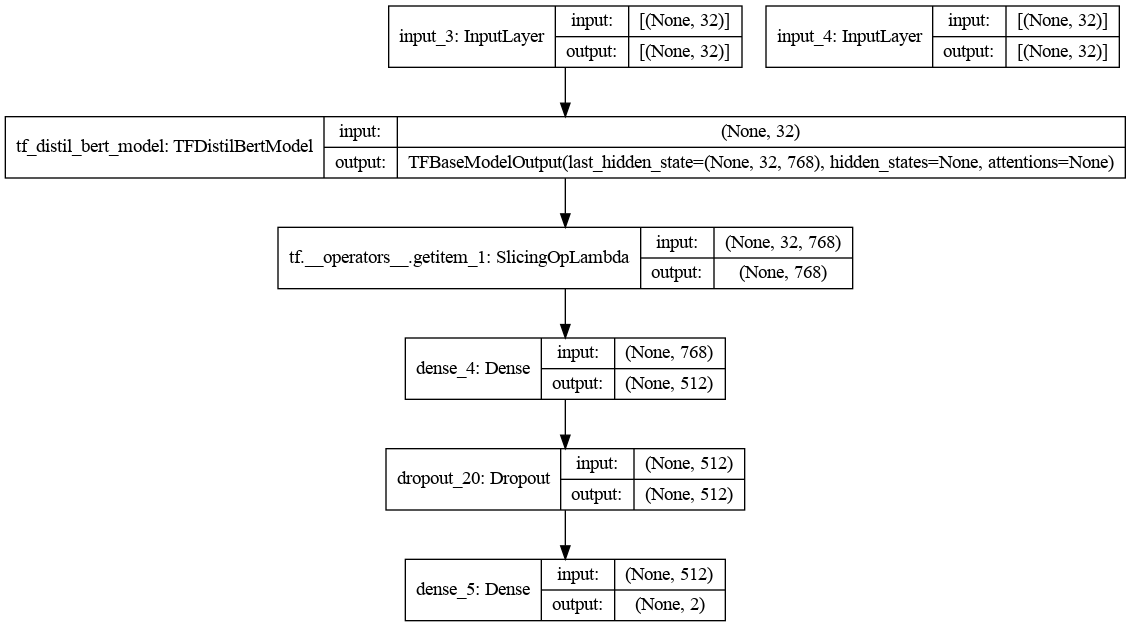

In [53]:
from keras.utils.vis_utils import plot_model
plot_model(trained_model, to_file='bert_distill.png', show_shapes=True, show_layer_names=True)

In [36]:
preds = trained_model.predict([val_inp, val_mask], batch_size=16)
pred_labels_distilled = preds.argmax(axis=1)
f1 = f1_score(val_label, pred_labels_distilled)
f1


0.9328125

In [37]:
target_names=['not_disaster','disaster']
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label, pred_labels_distilled, target_names=target_names))

print('Training and saving built model.....')

F1 score 0.9328125
Classification Report
              precision    recall  f1-score   support

not_disaster       0.94      0.96      0.95       875
    disaster       0.94      0.92      0.93       648

    accuracy                           0.94      1523
   macro avg       0.94      0.94      0.94      1523
weighted avg       0.94      0.94      0.94      1523

Training and saving built model.....


In [39]:
# Modefied from Source: https://github.com/DTrimarchi10/confusion_matrix
eval_labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['not_deisaster', 'disaster']

def model_peformance(y_test, predicted_prob,
                          group_names=eval_labels,
                          categories=categories,
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title='Confusion Matrix'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''
    
    predicted = predicted_prob.argmax(axis=1)
    predicted_prob = predicted_prob[:, 1]
    
    cf = confusion_matrix(y_test, predicted)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # MAKE THE HEATMAP VISUALIZATION
#     plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax = ax[0])

    if xyplotlabels:
        ax[0].set_ylabel('True label')
        ax[0].set_xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        ax[0].set_title(title)
        
# Plot ROC Curve    
    auc = roc_auc_score(y_test, predicted_prob)
#     print('Area Under the Receiver Operating Characteristic Curve = ', auc)
    fpr, tpr, _ =  roc_curve(y_test, predicted_prob)

    ax[1].plot(fpr, tpr, marker='.', label='(AUROC = %0.3f)' % auc)

    # Title
    ax[1].set_title('ROC Plot')
    # Axis labels
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    fig.suptitle('Model Performance on the Test Dataset')
    
    plt.show()
    print('\nDetails:')
    print(classification_report(y_test, predicted))



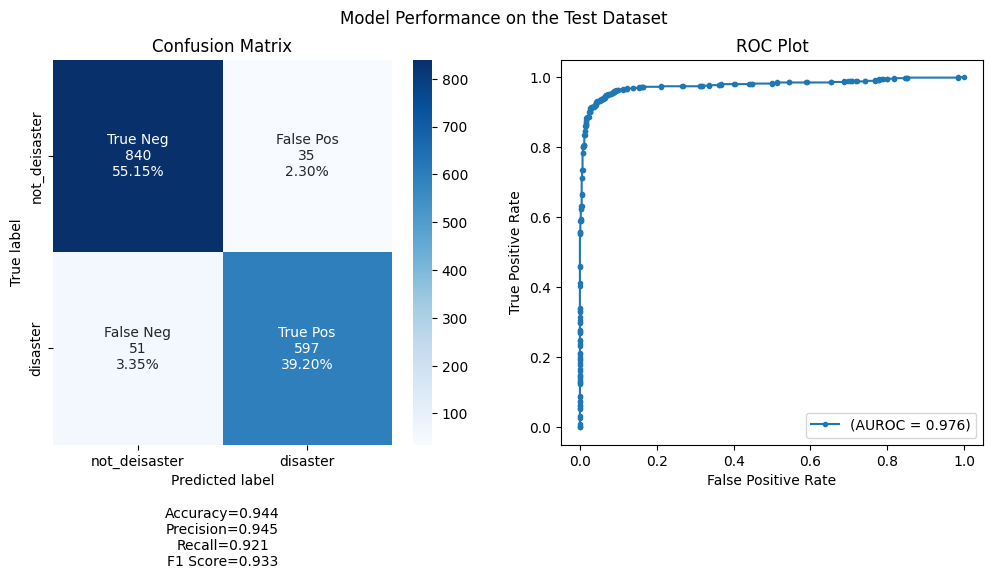


Details:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       875
           1       0.94      0.92      0.93       648

    accuracy                           0.94      1523
   macro avg       0.94      0.94      0.94      1523
weighted avg       0.94      0.94      0.94      1523



In [40]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc

model_peformance(val_label, preds)

# Using Larger Bert Transformer: 'bert-base-uncased'

In [58]:
 dbert_base_tokenizer(sentences[4])

{'input_ids': [101, 2288, 2741, 6302, 10090, 7397, 5610, 3748, 26332, 10364, 2015, 2082, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [41]:
# loading Bert Tokenizer
dbert_base_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [42]:
# loading Bert Model
dbert_base_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [43]:
num_classes = 2
def create_model_base():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_base_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [44]:
base_model = create_model_base()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_bert_model[0][0]        

In [45]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps = dbert_base_tokenizer.encode_plus(sent,
                                           add_special_tokens = True,
                                           max_length = max_len, padding ='max_length',
                                           return_attention_mask = True,
                                           truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
labels = np.array(labels)

In [46]:
input_ids.shape, attention_masks.shape, labels.shape

((7613, 32), (7613, 32), (7613,))

In [47]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(input_ids, labels, attention_masks, test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape, val_inp.shape, train_label.shape, val_label.shape, train_mask.shape, val_mask.shape))


log_dir='dbert_base_model'
model_base_save_path='./dbert_base_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path, 
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True), 
                                                keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

base_model.compile(loss=loss, optimizer= optimizer, metrics=[metric])


Train inp shape (6090, 32) Val input shape (1523, 32)
Train label shape (6090,) Val label shape (1523,)
Train attention mask shape (6090, 32) Val attention mask shape (1523, 32)


In [271]:
callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only = True, monitor='val_loss', mode='min', save_best_only=True), keras.callbacks.TensorBoard(log_dir=log_dir)]
base_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [272]:

history = base_model.fit([train_inp, train_mask], train_label, batch_size=16, epochs=30, validation_data = ([val_inp, val_mask], val_label), callbacks=callbacks)

Epoch 1/30


/home/ahmed/anaconda3/envs/capstone3/lib/python3.9/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


381/381 [==============================] - 1149s 3s/step - loss: 5.9184 - accuracy: 0.7931 - val_loss: 5.1638 - val_accuracy: 0.8313
Epoch 2/30
381/381 [==============================] - 1141s 3s/step - loss: 4.4923 - accuracy: 0.8644 - val_loss: 4.0413 - val_accuracy: 0.8345
Epoch 3/30
381/381 [==============================] - 1149s 3s/step - loss: 3.3587 - accuracy: 0.9136 - val_loss: 3.2850 - val_accuracy: 0.8004
Epoch 4/30
381/381 [==============================] - 1140s 3s/step - loss: 2.4732 - accuracy: 0.9475 - val_loss: 2.5729 - val_accuracy: 0.8221
Epoch 5/30
381/381 [==============================] - 1140s 3s/step - loss: 1.8308 - accuracy: 0.9624 - val_loss: 2.4960 - val_accuracy: 0.7708
Epoch 6/30
381/381 [==============================] - 1136s 3s/step - loss: 1.3541 - accuracy: 0.9724 - val_loss: 1.9545 - val_accuracy: 0.8155
Epoch 7/30
381/381 [==============================] - 1136s 3s/step - loss: 1.0034 - accuracy: 0.9762 - val_loss: 1.7540 - val_accuracy: 0.7912
Epo

In [48]:
trained_base_model = create_model_base()
trained_base_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_base_model.load_weights(model_base_save_path)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 768)          0           tf_bert_model[1][0]        

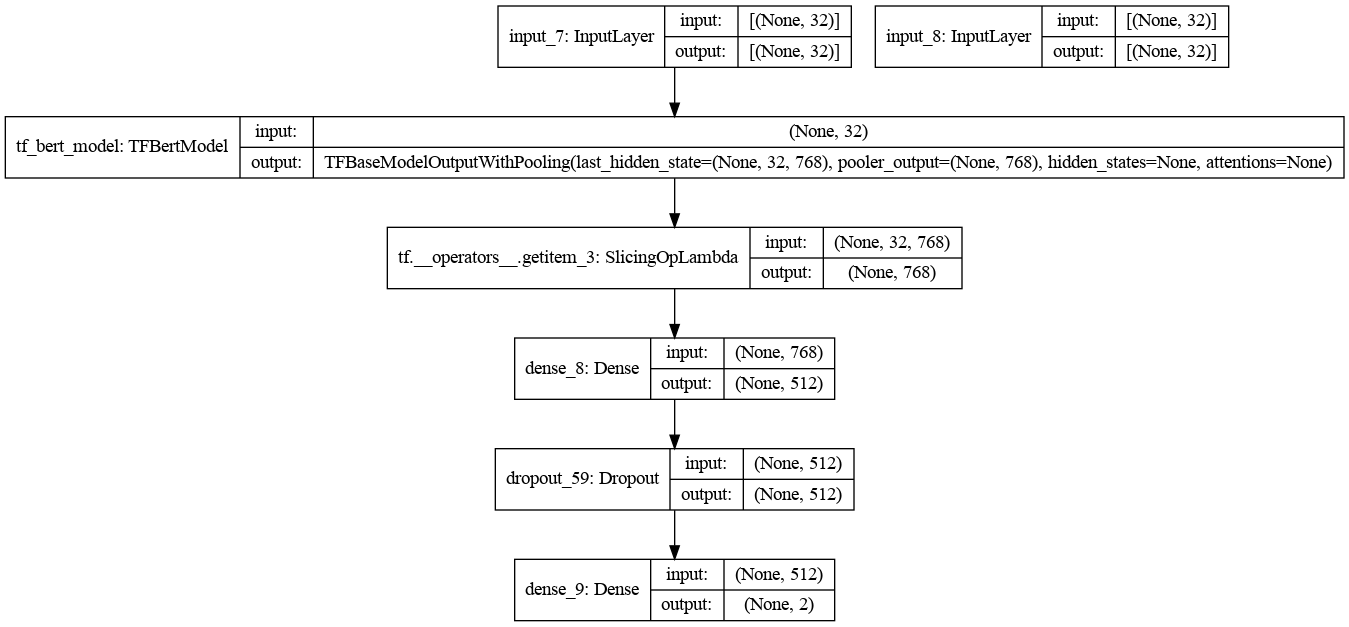

In [51]:
plot_model(trained_base_model, to_file='bert_base.png', show_shapes=True, show_layer_names=True)

In [50]:
preds = trained_base_model.predict([val_inp,val_mask], batch_size=16)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
f1


0.943683409436834

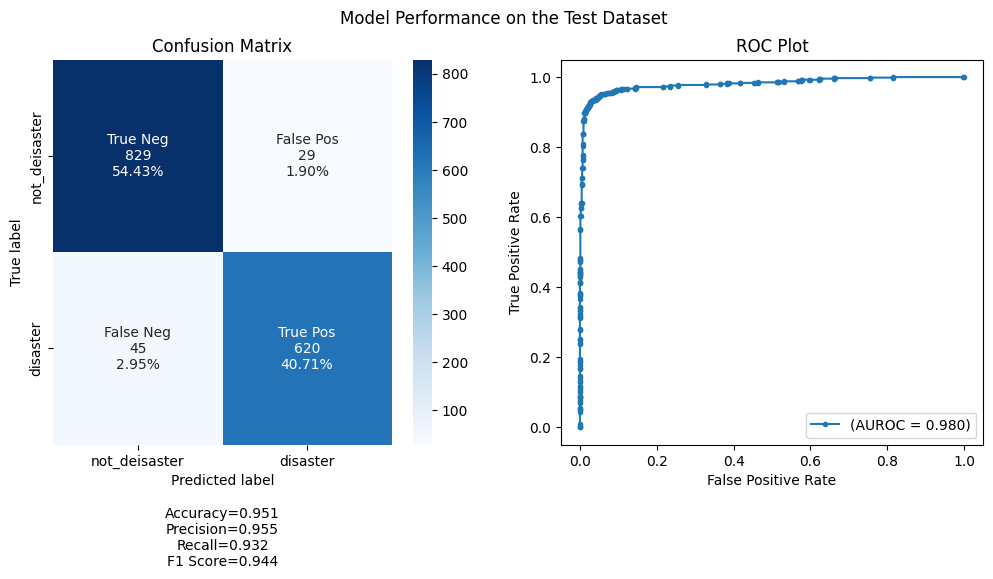


Details:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       858
           1       0.96      0.93      0.94       665

    accuracy                           0.95      1523
   macro avg       0.95      0.95      0.95      1523
weighted avg       0.95      0.95      0.95      1523



In [52]:
model_peformance(val_label, preds)

# Conclusion
- Both BertDistill and Bert_large_uncased have produced the best performance.
- Bert_large_uncased is the winning model with slightly better performance.
- However, training Bert_large_uncased with 109,876,994 trainable parameters for 30 epochs required more than 9 hours on 16GB Ram / 4 cores CPU laptop.
- Next we verify the winning model performance on the unlabeled tweets in the test dataset.

# Test Data Set

In [77]:
test_ids = []
test_masks = []

for sent in test_df.text:
    dbert_inps = dbert_base_tokenizer.encode_plus(sent,
                                           add_special_tokens = True,
                                           max_length = max_len, padding ='max_length',
                                           return_attention_mask = True,
                                           truncation=True)
    test_ids.append(dbert_inps['input_ids'])
    test_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(test_ids)
attention_masks = np.array(test_masks)
# labels = np.array(labels)

### Generate predictions

In [78]:
preds = trained_base_model.predict([input_ids,attention_masks], batch_size=16)
pred_labels = preds.argmax(axis=1)


In [69]:
preds

array([[0.86059684, 0.1394032 ],
       [0.00212362, 0.9978764 ],
       [0.00204204, 0.99795794],
       ...,
       [0.01573453, 0.98426545],
       [0.00182463, 0.9981754 ],
       [0.00162844, 0.99837154]], dtype=float32)

In [73]:
pred_labels.shape

(7613,)

In [75]:
test_df.shape

(3263, 1)

In [113]:
predicted_test = pd.read_csv(datapath + 'interim_test_df.csv')

In [114]:
predicted_test['Disaster Prediction'] = pred_labels

In [115]:
predicted_test[:30]

,text,Disaster Prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, stay safe everyone.",1
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1
5,We're shaking...It's an earthquake,1
6,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",0
7,Hey! How are you?,0
8,What a nice hat?,0
9,Fuck off!,0
